# Analisis de datos en Julia

using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Dates")
Pkg.add("Plots")

In [1]:
using CSV
using DataFrames
using Dates
using Plots

In [2]:
# Step 1: Specify the file location
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

# Step 2: Specify the path

path = pwd()*"/Data/confirmed.csv"

# Step 3: Download the file
download(URL, path)

"/home/silverwolf/Documents/Proyectos AI/JuliaCVML/Semana 1/Data/confirmed.csv"

In [3]:
?CSV.File

```
CSV.File(input; kwargs...) => CSV.File
```

Read a UTF-8 CSV input and return a `CSV.File` object, which is like a lightweight table/dataframe, allowing dot-access to columns and iterating rows. Satisfies the Tables.jl interface, so can be passed to any valid sink, yet to avoid unnecessary copies of data, use `CSV.read(input, sink; kwargs...)` instead if the `CSV.File` intermediate object isn't needed.

The [`input`](@ref input) argument can be one of:

  * filename given as a string or FilePaths.jl type
  * a `Vector{UInt8}` or `SubArray{UInt8, 1, Vector{UInt8}}` byte buffer
  * a `CodeUnits` object, which wraps a `String`, like `codeunits(str)`
  * a csv-formatted string can also be passed like `IOBuffer(str)`
  * a `Cmd` or other `IO`
  * a gzipped file (or gzipped data in any of the above), which will automatically be decompressed for parsing
  * a `Vector` of any of the above, which will parse and vertically concatenate each source, returning a single, "long" `CSV.File`

To read a csv file from a url, use the Downloads.jl stdlib or HTTP.jl package, where the resulting downloaded tempfile or `HTTP.Response` body can be passed like:

```julia
using Downloads, CSV
f = CSV.File(Downloads.download(url))

# or

using HTTP, CSV
f = CSV.File(HTTP.get(url).body)
```

Opens the file or files and uses passed arguments to detect the number of columns and column types, unless column types are provided manually via the `types` keyword argument. Note that passing column types manually can slightly increase performance for each column type provided (column types can be given as a `Vector` for all columns, or specified per column via name or index in a `Dict`).

When a `Vector` of inputs is provided, the column names and types of each separate file/input must match to be vertically concatenated. Separate threads will be used to parse each input, which will each parse their input using just the single thread. The results of all threads are then vertically concatenated using `ChainedVector`s to lazily concatenate each thread's columns.

For text encodings other than UTF-8, load the [StringEncodings.jl](https://github.com/JuliaStrings/StringEncodings.jl) package and call e.g. `CSV.File(open(read, input, enc"ISO-8859-1"))`.

The returned `CSV.File` object supports the [Tables.jl](https://github.com/JuliaData/Tables.jl) interface and can iterate `CSV.Row`s. `CSV.Row` supports `propertynames` and `getproperty` to access individual row values. `CSV.File` also supports entire column access like a `DataFrame` via direct property access on the file object, like `f = CSV.File(file); f.col1`. Or by getindex access with column names, like `f[:col1]` or `f["col1"]`. The returned columns are `AbstractArray` subtypes, including: `SentinelVector` (for integers), regular `Vector`, `PooledVector` for pooled columns, `MissingVector` for columns of all `missing` values, `PosLenStringVector` when `stringtype=PosLenString` is passed, and `ChainedVector` will chain one of the previous array types together for data inputs that use multiple threads to parse (each thread parses a single "chain" of the input). Note that duplicate column names will be detected and adjusted to ensure uniqueness (duplicate column name `a` will become `a_1`). For example, one could iterate over a csv file with column names `a`, `b`, and `c` by doing:

```julia
for row in CSV.File(file)
    println("a=$(row.a), b=$(row.b), c=$(row.c)")
end
```

By supporting the Tables.jl interface, a `CSV.File` can also be a table input to any other table sink function. Like:

```julia
# materialize a csv file as a DataFrame, copying columns from CSV.File
df = CSV.File(file) |> DataFrame

# to avoid making a copy of parsed columns, use CSV.read
df = CSV.read(file, DataFrame)

# load a csv file directly into an sqlite database table
db = SQLite.DB()
tbl = CSV.File(file) |> SQLite.load!(db, "sqlite_table")
```

# Arguments

## File layout options:

  * `header=1`: how column names should be determined; if given as an `Integer`, indicates the row to parse for column names; as an `AbstractVector{<:Integer}`, indicates a set of rows to be concatenated together as column names; `Vector{Symbol}` or `Vector{String}` give column names explicitly (should match # of columns in dataset); if a dataset doesn't have column names, either provide them as a `Vector`, or set `header=0` or `header=false` and column names will be auto-generated (`Column1`, `Column2`, etc.). Note that if a row number header and `comment` or `ignoreemptyrows` are provided, the header row will be the first non-commented/non-empty row *after* the row number, meaning if the provided row number is a commented row, the header row will actually be the next non-commented row.
  * `normalizenames::Bool=false`: whether column names should be "normalized" into valid Julia identifier symbols; useful when using the `tbl.col1` `getproperty` syntax or iterating rows and accessing column values of a row via `getproperty` (e.g. `row.col1`)
  * `skipto::Integer`: specifies the row where the data starts in the csv file; by default, the next row after the `header` row(s) is used. If `header=0`, then the 1st row is assumed to be the start of data; providing a `skipto` argument does *not* affect the `header` argument. Note that if a row number `skipto` and `comment` or `ignoreemptyrows` are provided, the data row will be the first non-commented/non-empty row *after* the row number, meaning if the provided row number is a commented row, the data row will actually be the next non-commented row.
  * `footerskip::Integer`: number of rows at the end of a file to skip parsing.  Do note that commented rows (see the `comment` keyword argument) *do not* count towards the row number provided for `footerskip`, they are completely ignored by the parser
  * `transpose::Bool`: read a csv file "transposed", i.e. each column is parsed as a row
  * `comment::String`: string that will cause rows that begin with it to be skipped while parsing. Note that if a row number header or `skipto` and `comment` are provided, the header/data row will be the first non-commented/non-empty row *after* the row number, meaning if the provided row number is a commented row, the header/data row will actually be the next non-commented row.
  * `ignoreemptyrows::Bool=true`: whether empty rows in a file should be ignored (if `false`, each column will be assigned `missing` for that empty row)
  * `select`: an `AbstractVector` of `Integer`, `Symbol`, `String`, or `Bool`, or a "selector" function of the form `(i, name) -> keep::Bool`; only columns in the collection or for which the selector function returns `true` will be parsed and accessible in the resulting `CSV.File`. Invalid values in `select` are ignored.
  * `drop`: inverse of `select`; an `AbstractVector` of `Integer`, `Symbol`, `String`, or `Bool`, or a "drop" function of the form `(i, name) -> drop::Bool`; columns in the collection or for which the drop function returns `true` will ignored in the resulting `CSV.File`. Invalid values in `drop` are ignored.
  * `limit`: an `Integer` to indicate a limited number of rows to parse in a csv file; use in combination with `skipto` to read a specific, contiguous chunk within a file; note for large files when multiple threads are used for parsing, the `limit` argument may not result in an exact # of rows parsed; use `threaded=false` to ensure an exact limit if necessary
  * `buffer_in_memory`: a `Bool`, default `false`, which controls whether a `Cmd`, `IO`, or gzipped source will be read/decompressed in memory vs. using a temporary file.
  * `ntasks::Integer=Threads.nthreads()`: [not applicable to `CSV.Rows`] for multithreaded parsed files, this controls the number of tasks spawned to read a file in concurrent chunks; defaults to the # of threads Julia was started with (i.e. `JULIA_NUM_THREADS` environment variable or `julia -t N`); setting `ntasks=1` will avoid any calls to `Threads.@spawn` and just read the file serially on the main thread; a single thread will also be used for smaller files by default (< 5_000 cells)
  * `rows_to_check::Integer=30`: [not applicable to `CSV.Rows`] a multithreaded parsed file will be split up into `ntasks` # of equal chunks; `rows_to_check` controls the # of rows are checked to ensure parsing correctly found valid rows; for certain files with very large quoted text fields, `lines_to_check` may need to be higher (10, 30, etc.) to ensure parsing correctly finds these rows
  * `source`: [only applicable for vector of inputs to `CSV.File`] a `Symbol`, `String`, or `Pair` of `Symbol` or `String` to `Vector`. As a single `Symbol` or `String`, provides the column name that will be added to the parsed columns, the values of the column will be the input "name" (usually file name) of the input from whence the value was parsed. As a `Pair`, the 2nd part of the pair should be a `Vector` of values matching the length of the # of inputs, where each value will be used instead of the input name for that inputs values in the auto-added column.

## Parsing options:

  * `missingstring`: either a `nothing`, `String`, or `Vector{String}` to use as sentinel values that will be parsed as `missing`; if `nothing` is passed, no sentinel/missing values will be parsed; by default, `missingstring=""`, which means only an empty field (two consecutive delimiters) is considered `missing`
  * `delim=','`: a `Char` or `String` that indicates how columns are delimited in a file; if no argument is provided, parsing will try to detect the most consistent delimiter on the first 10 rows of the file
  * `ignorerepeated::Bool=false`: whether repeated (consecutive/sequential) delimiters should be ignored while parsing; useful for fixed-width files with delimiter padding between cells
  * `quoted::Bool=true`: whether parsing should check for `quotechar` at the start/end of cells
  * `quotechar='"'`, `openquotechar`, `closequotechar`: a `Char` (or different start and end characters) that indicate a quoted field which may contain textual delimiters or newline characters
  * `escapechar='"'`: the `Char` used to escape quote characters in a quoted field
  * `dateformat::Union{String, Dates.DateFormat, Nothing, AbstractDict}`: a date format string to indicate how Date/DateTime columns are formatted for the entire file; if given as an `AbstractDict`, date format strings to indicate how the Date/DateTime columns corresponding to the keys are formatted. The Dict can map column index `Int`, or name `Symbol` or `String` to the format string for that column.
  * `decimal='.'`: a `Char` indicating how decimals are separated in floats, i.e. `3.14` uses `'.'`, or `3,14` uses a comma `','`
  * `truestrings`, `falsestrings`: `Vector{String}`s that indicate how `true` or `false` values are represented; by default `"true", "True", "TRUE", "T", "1"` are used to detect `true` and `"false", "False", "FALSE", "F", "0"` are used to detect `false`; note that columns with only `1` and `0` values will default to `Int64` column type unless explicitly requested to be `Bool` via `types` keyword argument
  * `stripwhitespace=false`: if true, leading and trailing whitespace are stripped from string values, including column names

## Column Type Options:

  * `types`: a single `Type`, `AbstractVector` or `AbstractDict` of types, or a function of the form `(i, name) -> Union{T, Nothing}` to be used for column types; if a single `Type` is provided, *all* columns will be parsed with that single type; an `AbstractDict` can map column index `Integer`, or name `Symbol` or `String` to type for a column, i.e. `Dict(1=>Float64)` will set the first column as a `Float64`, `Dict(:column1=>Float64)` will set the column named `column1` to `Float64` and, `Dict("column1"=>Float64)` will set the `column1` to `Float64`; if a `Vector` is provided, it must match the # of columns provided or detected in `header`. If a function is provided, it takes a column index and name as arguments, and should return the desired column type for the column, or `nothing` to signal the column's type should be detected while parsing.
  * `typemap::Dict{Type, Type}`: a mapping of a type that should be replaced in every instance with another type, i.e. `Dict(Float64=>String)` would change every detected `Float64` column to be parsed as `String`; only "standard" types are allowed to be mapped to another type, i.e. `Int64`, `Float64`, `Date`, `DateTime`, `Time`, and `Bool`. If a column of one of those types is "detected", it will be mapped to the specified type.
  * `pool::Union{Bool, Real, AbstractVector, AbstractDict, Function, Tuple{Float64, Int}}=(0.2, 500)`: [not supported by `CSV.Rows`] controls whether columns will be built as `PooledArray`; if `true`, all columns detected as `String` will be pooled; alternatively, the proportion of unique values below which `String` columns should be pooled (meaning that if the # of unique strings in a column is under 25%, `pool=0.25`, it will be pooled). If provided as a `Tuple{Float64, Int}` like `(0.2, 500)`, it represents the percent cardinality threshold as the 1st tuple element (`0.2`), and an upper limit for the # of unique values (`500`), under which the column will be pooled; this is the default (`pool=(0.2, 500)`). If an `AbstractVector`, each element should be `Bool`, `Real`, or `Tuple{Float64, Int}` and the # of elements should match the # of columns in the dataset; if an `AbstractDict`, a `Bool`, `Real`, or `Tuple{Float64, Int}` value can be provided for individual columns where the dict key is given as column index `Integer`, or column name as `Symbol` or `String`. If a function is provided, it should take a column index and name as 2 arguments, and return a `Bool`, `Real`, `Tuple{Float64, Int}`, or `nothing` for each column.
  * `downcast::Bool=false`: controls whether columns detected as `Int64` will be "downcast" to the smallest possible integer type like `Int8`, `Int16`, `Int32`, etc.
  * `stringtype=InlineStrings.InlineString`: controls how detected string columns will ultimately be returned; default is `InlineString`, which stores string data in a fixed-size primitive type that helps avoid excessive heap memory usage; if a column has values longer than 32 bytes, it will default to `String`. If `String` is passed, all string columns will just be normal `String` values. If `PosLenString` is passed, string columns will be returned as `PosLenStringVector`, which is a special "lazy" `AbstractVector` that acts as a "view" into the original file data. This can lead to the most efficient parsing times, but note that the "view" nature of `PosLenStringVector` makes it read-only, so operations like `push!`, `append!`, or `setindex!` are not supported. It also keeps a reference to the entire input dataset source, so trying to modify or delete the underlying file, for example, may fail
  * `strict::Bool=false`: whether invalid values should throw a parsing error or be replaced with `missing`
  * `silencewarnings::Bool=false`: if `strict=false`, whether invalid value warnings should be silenced
  * `maxwarnings::Int=100`: if more than `maxwarnings` number of warnings are printed while parsing, further warnings will be silenced by default; for multithreaded parsing, each parsing task will print up to `maxwarnings`
  * `debug::Bool=false`: passing `true` will result in many informational prints while a dataset is parsed; can be useful when reporting issues or figuring out what is going on internally while a dataset is parsed
  * `validate::Bool=true`: whether or not to validate that columns specified in the `types`, `dateformat` and `pool` keywords are actually found in the data. If `false` no validation is done, meaning no error will be thrown if `types`/`dateformat`/`pool` specify settings for columns not actually found in the data.

## Iteration options:

  * `reusebuffer=false`: [only supported by `CSV.Rows`] while iterating, whether a single row buffer should be allocated and reused on each iteration; only use if each row will be iterated once and not re-used (e.g. it's not safe to use this option if doing `collect(CSV.Rows(file))` because only current iterated row is "valid")


In [13]:
# Step 4: Reading the CSV file into a DataFrame
df = CSV.File(path)|> DataFrame

,Province/State,Country/Region,Lat,Long,1/22/20
,String?,String,Float64?,Float64?,Int64
1,missing,Afghanistan,33.9391,67.71,0
2,missing,Albania,41.1533,20.1683,0
3,missing,Algeria,28.0339,1.6596,0
4,missing,Andorra,42.5063,1.5218,0
5,missing,Angola,-11.2027,17.8739,0
6,missing,Antarctica,-71.9499,23.347,0
7,missing,Antigua and Barbuda,17.0608,-61.7964,0
8,missing,Argentina,-38.4161,-63.6167,0
9,missing,Armenia,40.0691,45.0382,0


In [5]:
first(df, 10)

,Province/State,Country/Region,Lat,Long,1/22/20
,String?,String,Float64?,Float64?,Int64
1,missing,Afghanistan,33.9391,67.71,0
2,missing,Albania,41.1533,20.1683,0
3,missing,Algeria,28.0339,1.6596,0
4,missing,Andorra,42.5063,1.5218,0
5,missing,Angola,-11.2027,17.8739,0
6,missing,Antarctica,-71.9499,23.347,0
7,missing,Antigua and Barbuda,17.0608,-61.7964,0
8,missing,Argentina,-38.4161,-63.6167,0
9,missing,Armenia,40.0691,45.0382,0


In [14]:
select!(df, Not(["Province/State", "Lat", "Long"]))

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,0,0,0,0,0,0,0
2,Albania,0,0,0,0,0,0,0
3,Algeria,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0
5,Angola,0,0,0,0,0,0,0
6,Antarctica,0,0,0,0,0,0,0
7,Antigua and Barbuda,0,0,0,0,0,0,0
8,Argentina,0,0,0,0,0,0,0
9,Armenia,0,0,0,0,0,0,0


In [15]:
df[ df."Country/Region".=="Australia", :]

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Australia,0,0,0,0,0,0,0,0
2,Australia,0,0,0,0,3,4,4,4
3,Australia,0,0,0,0,0,0,0,0
4,Australia,0,0,0,0,0,0,0,1
5,Australia,0,0,0,0,0,0,0,0
6,Australia,0,0,0,0,0,0,0,0
7,Australia,0,0,0,0,1,1,1,1
8,Australia,0,0,0,0,0,0,0,0


In [16]:
df

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,0,0,0,0,0,0,0
2,Albania,0,0,0,0,0,0,0
3,Algeria,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0
5,Angola,0,0,0,0,0,0,0
6,Antarctica,0,0,0,0,0,0,0
7,Antigua and Barbuda,0,0,0,0,0,0,0
8,Argentina,0,0,0,0,0,0,0
9,Armenia,0,0,0,0,0,0,0


In [17]:
grp = groupby(df, "Country/Region")
column_names = names(grp)
date_columns = column_names[2:end] # select all columns except the first column "Country/Region"
df = combine(grp, date_columns .=> sum .=> date_columns)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,0,0,0,0,0,0,0
2,Albania,0,0,0,0,0,0,0
3,Algeria,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0
5,Angola,0,0,0,0,0,0,0
6,Antarctica,0,0,0,0,0,0,0
7,Antigua and Barbuda,0,0,0,0,0,0,0
8,Argentina,0,0,0,0,0,0,0
9,Armenia,0,0,0,0,0,0,0


In [27]:
df = DataFrames.stack(
    df,
    Not("Country/Region"),
    "Country/Region",
    variable_name="Date",
    value_name="Cases",
)

,Country/Region,Date,Cases
,String,String,Int64
1,Afghanistan,1/22/20,0
2,Albania,1/22/20,0
3,Algeria,1/22/20,0
4,Andorra,1/22/20,0
5,Angola,1/22/20,0
6,Antarctica,1/22/20,0
7,Antigua and Barbuda,1/22/20,0
8,Argentina,1/22/20,0
9,Armenia,1/22/20,0


In [28]:
df.Date = Dates.Date.(df.Date |> Array, Dates.DateFormat("m/d/Y")) .+ Dates.Year(2000)

163944-element Vector{Date}:
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 2020-01-22
 ⋮
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28
 2022-04-28

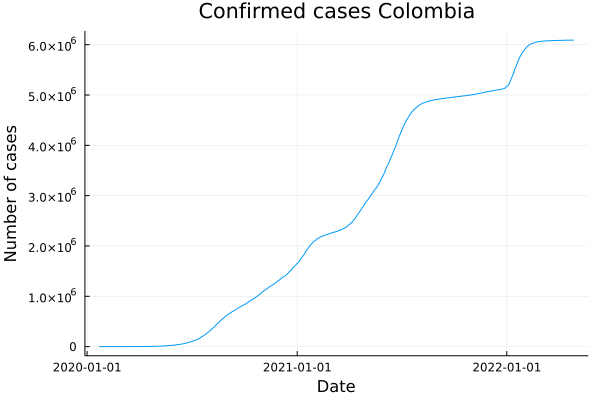

In [40]:
plot(
    df[df."Country/Region" .== "Colombia", :Date],
    df[df."Country/Region" .== "Colombia", :Cases],
    title = "Confirmed cases Colombia",
    xlabel = "Date",
    ylabel = "Number of cases",
    legend = false,
)